In [19]:
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import sys
sys.path.insert(1, './lib/')

# {Project Title} - Progress Report
### Team Diatonics | CS 418 | Spring 2020

### Team Members
* Leopoldo Gomez (`lgomez36@uic.edu`, `pologomez`)
* Matthew Searcy (`msearc2@uic.edu`, `MatthewSearcy`)
* Matt Rusnaczyk (`mrusna4@uic.edu`, `mrusnaczyk`)
* Faraz Shakir (`fshaki3@uic.edu`, `FShakir`)
* Mahdi Moghaddam (`mmogha2@uic.edu`, `mahdimo5595`)

------

## Project Introduction
In it's current form, the main idea of this project is to see if a clustering method can be used to subdivide a large pool of songs that are deemed to be part of the same genre into smaller subgenres. A potential audience for this analysis would be people who are trying to get into a new gerne. Being able to listen to a selection of songs from each subgroup could make it easier to figure out what type of bands they'd enjoy listening to. 

For our preliminary exploration into this topic we decided to use a precompiled [dataset](https://github.com/fivethirtyeight/data/blob/master/classic-rock/classic-rock-song-list.csv) of classic rock songs and get their audio features via spotify's API. We decided to use rock as our genre for this because it is one of the broadest genres of music with many distinct characteristic sounds and sub-cultures. If the preliminary results are fruitful we may continue on to broadening the genres we cluster from.

## Changes to Scope of Project
### Spotify Listening Trends Based on Time of Year
   Originally, our project was going to focus on the songs that gain popularity at different times of the year. We wondered if there was some correspondence between the properties of those songs and the time at which they reached peak popularity and see if we could predict the optimal time of year to release a new song given its properties.
   Our course of action was to fetch the top 100 songs from the Billboard charts every week of the year for the past 20 years. We would then retrieve the songs' properties using the Spotify API and organize the data for comparison and use machine learning to develop a way of classifying a song into seasons based on its properties.
   
   We decided to change our project's scope for a few reasons. When we examined the properties of the songs we gathered, virtually every week had a wide variety of levels of energy, key, loudness, etc. We concluded that there wasn't significance in the seasonality of the songs and that would likely lead to an inaccurate classification model. Since the hot-100 charts features songs of all varieties, we decided we'd have to hone in on a type of music to make the properties of the songs more similar. Additionally, a song that is on the Billbord hot-100 list often remains on the list for weeks, or even months. This resulted in complications in identifying the season that the song gained popularity, and would likely affect the learning.

---

## Data Acquisition and Cleaning
Our analysis is based on two sets of data. The first is the [Classic Rock Song List from FiveThirtyEight](https://github.com/fivethirtyeight/data/blob/master/classic-rock/classic-rock-song-list.csv); the second is the audio features data made available by Spotify through their [RESTful API](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/).

First, we read in the data from the classic rock songs dataset, then we transform the data into a list consisting of each track and artist concatenated into one string. Converting into this format allows us to more easily search for the tracks in Spotify later on.

In [20]:
# the CSV file containing titles and artists/bands
songs = pd.read_csv("data/classic-rock-song-list.csv")

# extracting title and names of the artists/bands
titles = songs['Song Clean'].tolist()
artists = songs['ARTIST CLEAN'].tolist()

# creating a list of titles+aritsts to be queried
title_artist = []
for i in range(0, len(titles)):
    title_artist.append(titles[i] + " " + artists[i])

Next, we take the title/artist strings we generated earlier, and retrieve the corresponding Spotify resource URLs for each:

In [ ]:
import spotify

spotify_client = spotify.get_spotify_client()

# getting the urls of each song
urls = spotify.get_spotify_resource_url(title_artist, spotify_client)

Then, we use the Spotify API to retrieve the audio features for each of the songs in the list, and add the track name and artist back in:

In [22]:
import data_acquisition_cleaning

# gets the audio features of each song
dataframe = data_acquisition_cleaning.audio_features(urls, spotify_client)
dataframe['artist'] = songs['ARTIST CLEAN']
dataframe['title'] = songs['Song Clean']

And this is the resulting dataset:

In [23]:
dataframe.head()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artist,title
0,0.425,0.681,1,-8.604,0.0316,0.02290,0.000219,0.0543,0.933,131.011,.38 Special,Caught Up in You
1,0.418,0.775,4,-9.591,0.0333,0.05310,0.001250,0.0932,0.845,123.524,.38 Special,Fantasy Girl
2,0.567,0.559,9,-10.175,0.0288,0.00888,0.001310,0.0764,0.898,127.227,.38 Special,Hold On Loosely
3,0.659,0.505,0,-12.773,0.0302,0.05300,0.000000,0.0544,0.879,128.295,.38 Special,Rockin' Into the Night
4,0.646,0.426,0,-10.629,0.0480,0.08580,0.072700,0.0746,0.462,124.794,10cc,Art For Arts Sake


---

## Exploratory Data Analysis

### `TODO`


In [24]:
eda_data = dataframe.copy().dropna()
try:
    eda_data = eda_data.drop(columns=['cluster', 'tempo'])
except:
    None

eda_data.describe()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,2162.000000,2162.000000,2162.00000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000,2162.000000
mean,0.524491,0.688754,5.03099,-8.947424,0.052556,0.183459,0.067891,0.206038,0.601561,124.159659
std,0.139991,0.192909,3.50097,3.337639,0.040627,0.219370,0.183718,0.187362,0.228299,27.002599
min,0.000000,0.012400,0.00000,-23.340000,0.000000,0.000001,0.000000,0.012000,0.000000,0.000000
25%,0.432000,0.555000,2.00000,-11.239000,0.032425,0.015200,0.000007,0.086450,0.430250,105.486500
50%,0.531000,0.715500,5.00000,-8.743000,0.039900,0.089950,0.000460,0.131000,0.615000,123.421000
75%,0.621750,0.847750,9.00000,-6.347250,0.056375,0.290000,0.015450,0.270000,0.786750,139.775000
max,0.952000,0.995000,11.00000,-1.525000,0.507000,0.971000,0.949000,0.992000,0.990000,215.918000


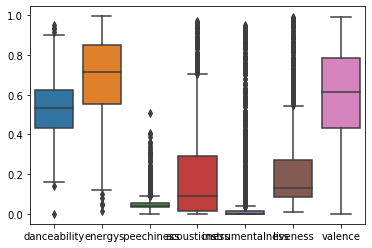

In [33]:
plot = sns.boxplot(data=eda_data.drop(columns=['tempo', 'loudness', 'key']))
plot.set_xticklabels(plot.get_xticklabels(), rotation=75)

---
## Machine Learning Analysis
### `TODO`

In [26]:
# scalling loudness key and tempo so the values of all features are between 0 and 1

scaler = MinMaxScaler()

scaler.fit(dataframe[['loudness']])
dataframe[['loudness']] = scaler.transform(dataframe[['loudness']])

scaler.fit(dataframe[['key']])
dataframe[['key']] = scaler.transform(dataframe[['key']])

scaler.fit(dataframe[['tempo']])
dataframe[['tempo']] = scaler.transform(dataframe[['tempo']])

In [27]:
# k-means clustering algorithm with 50 clusters

km = KMeans(n_clusters=50)
prediction = km.fit_predict(dataframe[['danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 
                                      'instrumentalness', 'liveness', 'valence', 'tempo']])
dataframe['cluster'] = prediction

In [28]:
dataframe.head()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artist,title,cluster
0,0.425,0.681,0.090909,0.675499,0.0316,0.02290,0.000219,0.0543,0.933,0.606763,.38 Special,Caught Up in You,45
1,0.418,0.775,0.363636,0.630254,0.0333,0.05310,0.001250,0.0932,0.845,0.572088,.38 Special,Fantasy Girl,31
2,0.567,0.559,0.818182,0.603484,0.0288,0.00888,0.001310,0.0764,0.898,0.589238,.38 Special,Hold On Loosely,37
3,0.659,0.505,0.000000,0.484391,0.0302,0.05300,0.000000,0.0544,0.879,0.594184,.38 Special,Rockin' Into the Night,26
4,0.646,0.426,0.000000,0.582672,0.0480,0.08580,0.072700,0.0746,0.462,0.577969,10cc,Art For Arts Sake,7


In [29]:
# returns a dataframe of songs similar a spicific song in dataframe

def recommend(song, dataframe):
    try:
        clt = dataframe[dataframe.title == song].cluster.values[0]
        df = dataframe[dataframe.cluster == clt][['title', 'artist']].reset_index().drop(columns=['index'])
        return df
    except:
        print('The requested song is not in dataframe.')

In [30]:
recommend('Back In Black', dataframe).head()

,title,artist
0,Back In Black,AC/DC
1,Night Prowler,AC/DC
2,"Baby, Please Don't Go",Aerosmith
3,Seasons of Wither,Aerosmith
4,Toys in the Attic,Aerosmith


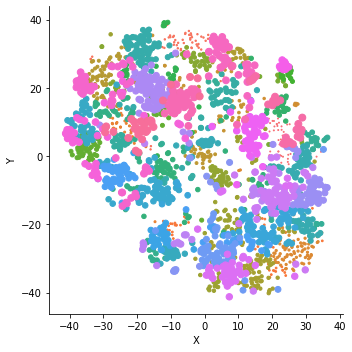

In [31]:
tsnedf = dataframe.drop(columns=['artist', 'title', 'cluster'])
model = TSNE(n_components=2, random_state=0, perplexity=50, learning_rate=900)
tsne_object = model.fit_transform(tsnedf)
tsne_df = pd.DataFrame(data=tsne_object, columns=('X', 'Y'))
tsne_df['cluster'] = prediction
sns.FacetGrid(tsne_df, hue='cluster', height=5).map(plt.scatter, 'X', 'Y', 'cluster')
plt.show()

In [32]:
dataframe['baseline'] = 0

i = 0
j = 0

while(True):
    if j+42 < len(urls):
        dataframe.loc[j:j+42,:].baseline = i
        j = j+43
        i = i+1
    else:
        dataframe.loc[j:len(urls),:].baseline = i
        break

/home/mateusz/.anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


---

## Reflection

For reference
- What is hardest part of the project that you’ve encountered so far?
- What are your initial insights?
- Are there any concrete results you can show at this point? If not, why not?
- Going forward, what are the current biggest problems you’re facing?

### `TODO`

---